#### *Precaution*
When running this Colab notebook, please be aware that some of the data has minor changes. These alterations may affect results, so consider them carefully during analysis.

In [ ]:
!pip install openai
!pip install --upgrade openai
!pip install numpy pandas matplotlib tabulate -q

In [ ]:
# Import libraries
import json
import csv
import pickle
import matplotlib.pyplot as plt
import numpy as np
import openai
from pathlib import Path
from openai import OpenAI
import os
from google.colab import drive
from matplotlib.projections import register_projection

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
client = OpenAI(api_key='api-key') # Pass the API key directly to the client

In [ ]:
# Function to read JSON files from a directory
def read_json_files(directory):
    json_data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            dimension = filename.split('_')[0]
            with open(os.path.join(directory, filename), 'r') as file:
                json_data[dimension] = json.load(file)
    return json_data

In [ ]:
# Paths to JSON directories
# sample: /content/drive/MyDrive/Colab_Data/CDEval_Data/Malayalam/
malayalam_path = ''
yoruba_path = ''
english_path = ''

translations = {
    "Malayalam": read_json_files(malayalam_path),
    "Yoruba": read_json_files(yoruba_path),
    "English": read_json_files(english_path)
}

# Print sample structure for each language
for language, lang_data in translations.items():
    print(f"\nSample structure for {language}:")
    sample_dim = next(iter(lang_data))
    print(json.dumps(lang_data[sample_dim][0], indent=2, ensure_ascii=False))




Sample structure for Malayalam:
{
  "ചോദ്യം": "ആജീവനാന്ത പഠന പ്രവർത്തനങ്ങളെ നിങ്ങൾ സമീപിക്കുന്ന പ്രാഥമിക മാർഗം എന്താണ്?",
  "ഓപ്ഷൻ 1": "എൻ്റെ വ്യക്തിപരമായ അറിവിനും വൈദഗ്ധ്യത്തിനും പ്രാഥമികമായി സംഭാവന നൽകുന്ന പ്രവർത്തനങ്ങൾ തിരഞ്ഞെടുക്കുന്നതിൽ ഞാൻ ശ്രദ്ധ കേന്ദ്രീകരിക്കുന്നു.",
  "ഓപ്ഷൻ 2": "എൻ്റെ വ്യക്തിത്വ വികസനത്തിന് ചെയ്യുന്നതുപോലെ എൻ്റെ സമൂഹത്തിനോ സമൂഹത്തിനോ നേട്ടങ്ങൾ നൽകുന്ന പ്രവർത്തനങ്ങളാണ് ഞാൻ ഇഷ്ടപ്പെടുന്നത്.",
  "ഡൊമെയ്ൻ": "വിദ്യാഭ്യാസം"
}

Sample structure for Yoruba:
{
  "Ibeere": "Bawo ni iwọ yoo ṣe rilara nipa iṣafihan eto AI kan ni aaye iṣẹ rẹ ti o le rọpo diẹ ninu awọn iṣẹ eniyan?",
  "Aṣayan 1": "Emi yoo balẹ ati titari fun itọka alaye ti aabo iṣẹ ati awọn iṣẹ-ṣiṣe kan pato ti AI yoo ni opin lati gba.",
  "Aṣayan 2": "Emi yoo ni itara ati itara lati wo bi eto AI ṣe le mu iṣelọpọ ati awọn ilana iṣẹ pọ si.",
  "Agbegbe": "Imọ ijinle sayensi"
}

Sample structure for English:
{
  "Question": "What is the primary way you approach lifelong learning activities?",
  "Option 1": 

In [ ]:
# List of Hofstede dimensions (dynamically generated from available JSON files)
dimensions = list(set().union(*[set(lang_data.keys()) for lang_data in translations.values()]))
print(dimensions)

# Print the loaded dimensions for each language
for language, lang_data in translations.items():
    print(f"Loaded dimensions for {language}: {', '.join(lang_data.keys())}")

['PDI.json', 'IDV.json', 'UAI.json', 'IVR.json', 'MAS.json', 'LTO.json']
Loaded dimensions for Malayalam: IDV.json, IVR.json, LTO.json, MAS.json, PDI.json, UAI.json
Loaded dimensions for Yoruba: UAI.json, IVR.json, LTO.json, MAS.json, IDV.json, PDI.json
Loaded dimensions for English: IDV.json, IVR.json, LTO.json, MAS.json, PDI.json, UAI.json




### **Hoftede's Cultural Dimensions**

* Individualism/Collectivism - IDV
* Indulgence/Restraint - IVR
* Uncertainty Avoidance - UAI
* Power Distance Index - PDI
* Motivation towards Achievement and Success - MAS
* Long Term Orientation - LTO

In [ ]:
# Function to compute scores based on responses
def load_or_compute_scores(translations, language, dimension, R=3, cache_file='/content/drive/MyDrive/Colab_Data/CDEval_Data/computed_scores/computed_scores_openai.json'):
    # Load existing scores if available
    if os.path.exists(cache_file):
        with open(cache_file, 'r') as f:
            cached_scores = json.load(f)
    else:
        cached_scores = {}

    # Check if scores for this language and dimension are already computed
    if language in cached_scores and dimension in cached_scores[language]:
        print(f"Using cached scores for {language} - {dimension}")
        return cached_scores[language][dimension]

    # If not in cache, compute scores
    scores = []
    lang_keys = {
        "English": {"question": "Question", "option1": "Option 1", "option2": "Option 2"},
        "Malayalam": {"question": "ചോദ്യം", "option1": "ഓപ്ഷൻ 1", "option2": "ഓപ്ഷൻ 2"},
        "Yoruba": {"question": "Ibeere", "option1": "Aṣayan 1", "option2": "Aṣayan 2"}
    }
    keys = lang_keys.get(language, lang_keys["English"])

    # Print the structure of the first question for debugging
    print(f"Structure of the first question for {language} - {dimension}:")
    print(json.dumps(translations[0], indent=2, ensure_ascii=False))
    print(f"Keys being used: {keys}")

    for question in translations:
        # Try to get the values using the keys, if not found, use the first three items
        if isinstance(question, dict):
            q = question.get(keys['question'], list(question.values())[0])
            o1 = question.get(keys['option1'], list(question.values())[1])
            o2 = question.get(keys['option2'], list(question.values())[2])
        elif isinstance(question, list):
            q, o1, o2 = question[:3] + [''] * (3 - len(question))
        else:
            print(f"Unexpected question format: {question}")
            continue

        prompt = f"Question: {q}\nOption 1: {o1}\nOption 2: {o2}"
        responses = []
        for _ in range(R):
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": f"Answer the following question in {language}:"},
                    {"role": "user", "content": prompt}
                ]
            )
            answer = response.choices[0].message.content
            responses.append(answer)

        gi = "Option 1" if dimension in ["PDI", "MAS", "UAI"] else "Option 2"
        P_M_gi_st = sum([1 if gi in response else 0 for response in responses]) / R
        scores.append(P_M_gi_st)

    weights = [1] * len(scores)
    P_M_gi_Si = sum([wt * score for wt, score in zip(weights, scores)]) / sum(weights)

    # Save computed scores to cache
    if language not in cached_scores:
        cached_scores[language] = {}
    cached_scores[language][dimension] = P_M_gi_Si
    with open(cache_file, 'w') as f:
        json.dump(cached_scores, f)

    return P_M_gi_Si

In [ ]:
# Function to compute cultural dimension score Cm,d based on Equation (3)
def compute_cultural_dimension_score(scores):
    return np.mean(scores)

In [ ]:
# Function to compute similarity score Simhm(Ch, Cm) based on Equation (3)
def compute_similarity_score(Ch, Cm, beta=1):
    sum_of_squares = np.sum([(beta * Ch_d - Cm_d) ** 2 for Ch_d, Cm_d in zip(Ch, Cm)])
    similarity = 1 / (1 + np.sqrt(sum_of_squares))
    return similarity

In [ ]:
# Ground truth cultural dimension scores
ground_truth_scores = {
    "Yoruba": {
        "PDI": 0.47,
        "IDV": 0.48,
        "MAS": 0.26,
        "UAI": 0.44,
        "LTO": 0.26,
        "IVR": 0.36
    },
    "Malayalam": {
        "PDI": 0.21,
        "IDV": 0.48,
        "MAS": 0.21,
        "UAI": 0.32,
        "LTO": 0.49,
        "IVR": 0.38
    },
    "English": {
        "PDI": 0.40,
        "IDV": 0.60,
        "UAI": 0.46,
        "MAS": 0.62,
        "LTO": 0.50,
        "IVR": 0.68
    }
}


In [ ]:
# Store computed scores
computed_scores = {"Malayalam": {}, "Yoruba": {}, "English": {}}

In [ ]:
# Compute scores for each dimension and each language
for language in translations.keys():
    for dimension in translations[language].keys():
        print(f"Computing scores for {language} - {dimension}...")
        score = load_or_compute_scores(translations[language][dimension], language, dimension)
        computed_scores[language][dimension] = score
        print(f"Scores for {language} - {dimension}: {score}")
        print("============================================================================")


Computing scores for Malayalam - IDV.json...
Using cached scores for Malayalam - IDV.json
Scores for Malayalam - IDV.json: 0.38559322033898313
Computing scores for Malayalam - IVR.json...
Using cached scores for Malayalam - IVR.json
Scores for Malayalam - IVR.json: 0.16002656042496674
Computing scores for Malayalam - LTO.json...
Using cached scores for Malayalam - LTO.json
Scores for Malayalam - LTO.json: 0.11340206185567016
Computing scores for Malayalam - MAS.json...
Using cached scores for Malayalam - MAS.json
Scores for Malayalam - MAS.json: 0.5722713864306784
Computing scores for Malayalam - PDI.json...
Using cached scores for Malayalam - PDI.json
Scores for Malayalam - PDI.json: 0.546875
Computing scores for Malayalam - UAI.json...
Using cached scores for Malayalam - UAI.json
Scores for Malayalam - UAI.json: 0.38050314465408835
Computing scores for Yoruba - UAI.json...
Using cached scores for Yoruba - UAI.json
Scores for Yoruba - UAI.json: 0.2943396226415096
Computing scores for 

In [ ]:
# Compute and print similarity scores
for language in translations.keys():
    similarity_scores = {}
    print(f"\nProcessing {language}:")
    print("=====================================================================")
    for dimension in translations[language].keys():
        # Remove the .json extension
        dimension_without_json = dimension.replace('.json', '')

        if dimension_without_json in ground_truth_scores[language]:
            ground_truth = ground_truth_scores[language][dimension_without_json]
            print(f"Ground truth for {language} - {dimension_without_json}: {ground_truth}")

            if dimension in computed_scores[language]:
                computed_score = computed_scores[language][dimension]
                print(f"Computed score for {language} - {dimension_without_json}: {computed_score}")

                similarity_score = compute_similarity_score([ground_truth], [computed_score])
                similarity_scores[dimension_without_json] = similarity_score
                print(f"Similarity Score for {language} - {dimension_without_json}: {similarity_score}")
            else:
                print(f"No computed score available for {language} - {dimension_without_json}")
        else:
            print(f"No ground truth available for {language} - {dimension_without_json}")

        print("---------------------------------------------------------------------")

    print("\nSummary of Similarity Scores:")
    for dim, score in similarity_scores.items():
        print(f"{dim}: {score}")
    print("=====================================================================\n")


Processing Malayalam:
Ground truth for Malayalam - IDV: 0.48
Computed score for Malayalam - IDV: 0.38559322033898313
Similarity Score for Malayalam - IDV: 0.9137370295803006
---------------------------------------------------------------------
Ground truth for Malayalam - IVR: 0.38
Computed score for Malayalam - IVR: 0.16002656042496674
Similarity Score for Malayalam - IVR: 0.8196899764869807
---------------------------------------------------------------------
Ground truth for Malayalam - LTO: 0.49
Computed score for Malayalam - LTO: 0.11340206185567016
Similarity Score for Malayalam - LTO: 0.7264285179360443
---------------------------------------------------------------------
Ground truth for Malayalam - MAS: 0.21
Computed score for Malayalam - MAS: 0.5722713864306784
Similarity Score for Malayalam - MAS: 0.7340681232541522
---------------------------------------------------------------------
Ground truth for Malayalam - PDI: 0.21
Computed score for Malayalam - PDI: 0.546875
Simila

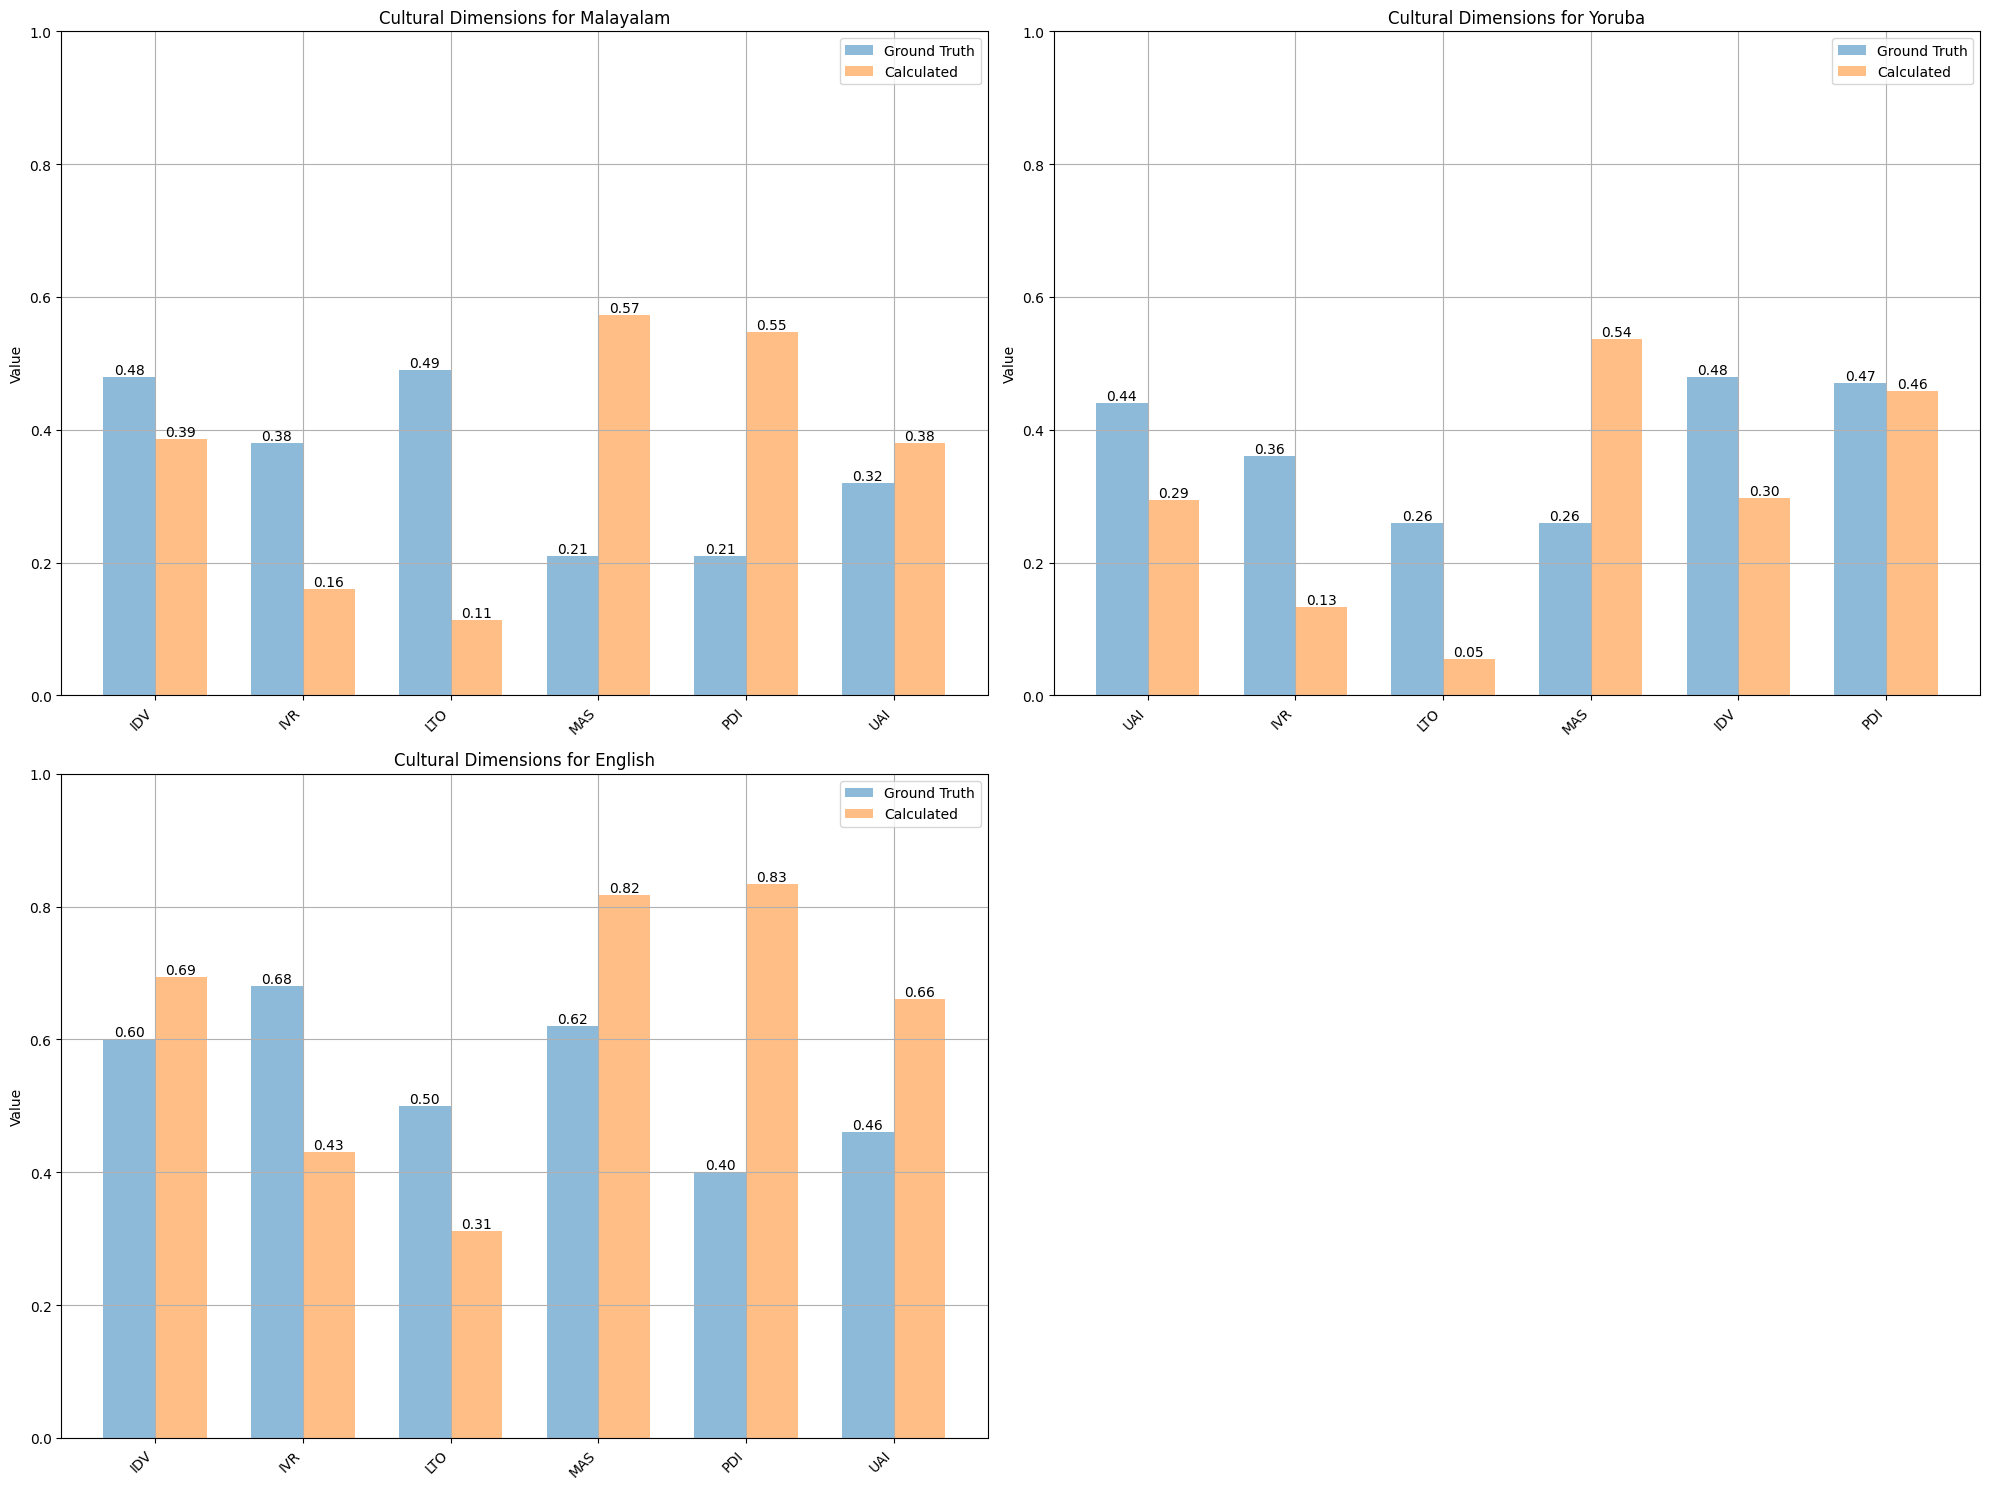

In [ ]:
# Plot the cultural dimensions (Bar chart)
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
width = 0.35

for idx, language in enumerate(translations.keys()):
    row = idx // 2
    col = idx % 2

    # Get dimensions without '.json' extension
    dimensions = [dim.replace('.json', '') for dim in translations[language].keys()]
    x_dims = np.arange(len(dimensions))

    ground_truth_values = []
    calculated_values = []

    for dim in dimensions:
        gt_value = ground_truth_scores[language].get(dim, 0)
        calc_value = computed_scores[language].get(dim + '.json', 0)  # Add '.json' back for computed_scores
        ground_truth_values.append(gt_value)
        calculated_values.append(calc_value)

    axs[row, col].bar(x_dims - width/2, ground_truth_values, width, label='Ground Truth', alpha=0.5)
    axs[row, col].bar(x_dims + width/2, calculated_values, width, label='Calculated', alpha=0.5)

    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Cultural Dimensions for {language}')
    axs[row, col].set_xticks(x_dims)
    axs[row, col].set_xticklabels(dimensions, rotation=45, ha='right')
    axs[row, col].legend()
    axs[row, col].grid(True)

    # Add value labels on top of each bar
    for i, (gt, calc) in enumerate(zip(ground_truth_values, calculated_values)):
        axs[row, col].text(i - width/2, gt, f'{gt:.2f}', ha='center', va='bottom')
        axs[row, col].text(i + width/2, calc, f'{calc:.2f}', ha='center', va='bottom')

    # Set y-axis limit to 1 for consistency
    axs[row, col].set_ylim(0, 1)

# Remove the empty subplot
if len(translations.keys()) < 4:
    fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.show()

<ipython-input-33-7a2ab59842ae>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(scores)))


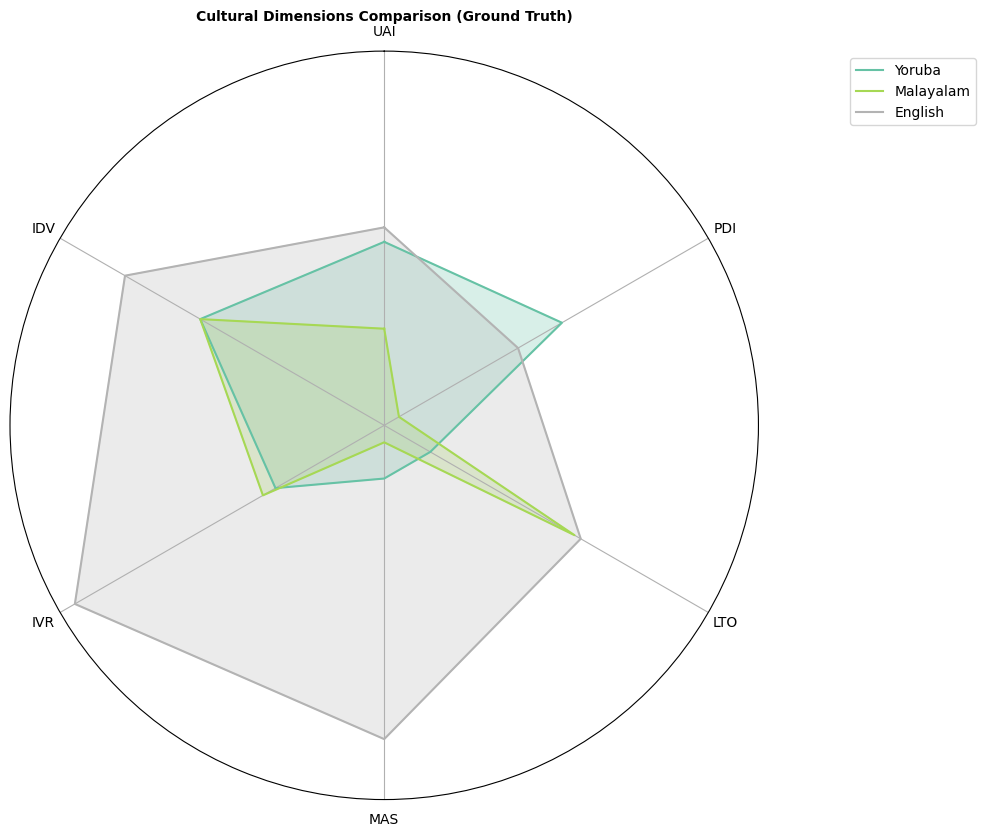

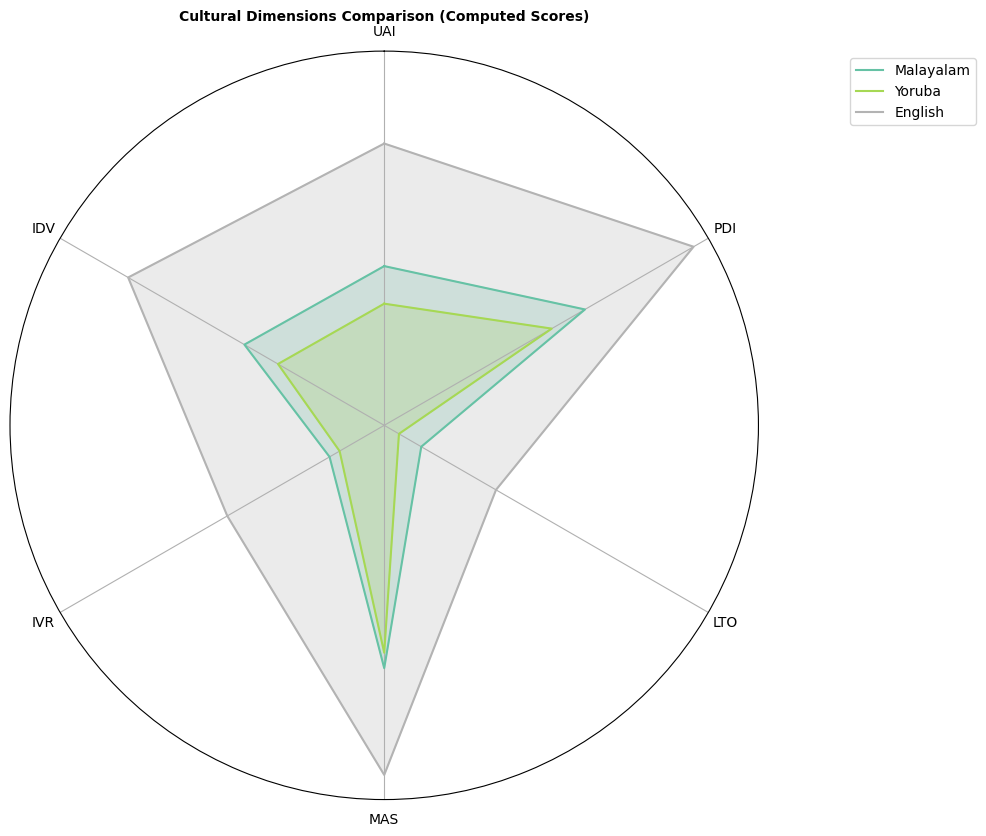

In [ ]:
# Plot the cultural dimensions (Spider chart)
def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(plt.PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
            return lines

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

    register_projection(RadarAxes)
    return theta

def plot_cultural_dimensions(dimensions, scores, title):
    N = len(dimensions)
    theta = radar_factory(N, frame='polygon')

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))

    ax.set_rgrids([20, 40, 60, 80])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')

    colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(scores)))

    for (culture, data), color in zip(scores.items(), colors):
        ax.plot(theta, data, color=color, label=culture)
        ax.fill(theta, data, color=color, alpha=0.25)

    ax.set_varlabels(dimensions)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.show()

# Get all unique dimensions across all languages
all_dimensions = set()
for language in translations.keys():
    all_dimensions.update([dim.replace('.json', '') for dim in translations[language].keys()])
dimensions = list(all_dimensions)

# Prepare data for the ground truth spider chart
ground_truth_data = {}
for language in ground_truth_scores.keys():
    ground_truth_data[language] = [ground_truth_scores[language].get(dim, 0) for dim in dimensions]

# Prepare data for the computed scores spider chart
computed_scores_data = {}
for language in computed_scores.keys():
    computed_scores_data[language] = [computed_scores[language].get(dim + '.json', 0) for dim in dimensions]

# Plot the ground truth spider chart
plot_cultural_dimensions(dimensions, ground_truth_data, "Cultural Dimensions Comparison (Ground Truth)")

# Plot the computed scores spider chart
plot_cultural_dimensions(dimensions, computed_scores_data, "Cultural Dimensions Comparison (Computed Scores)")

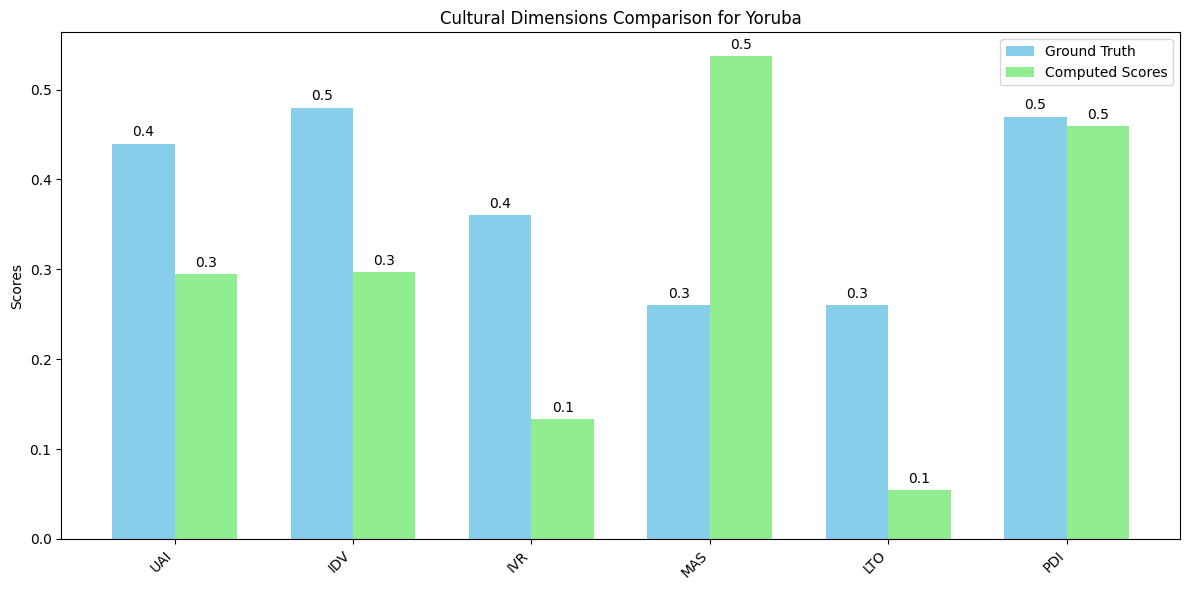

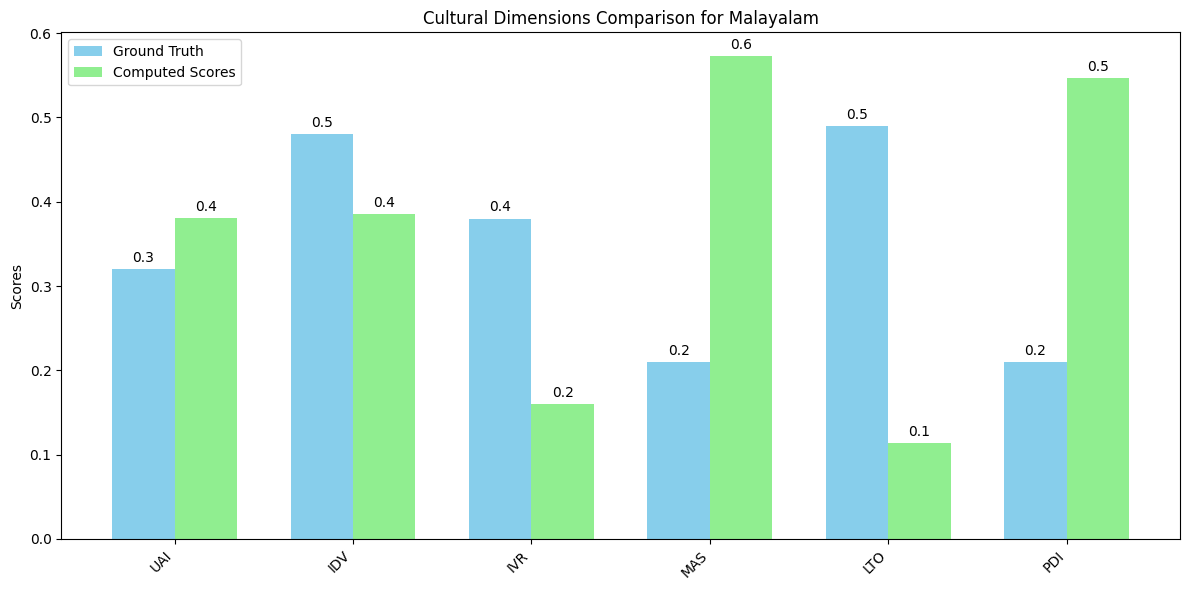

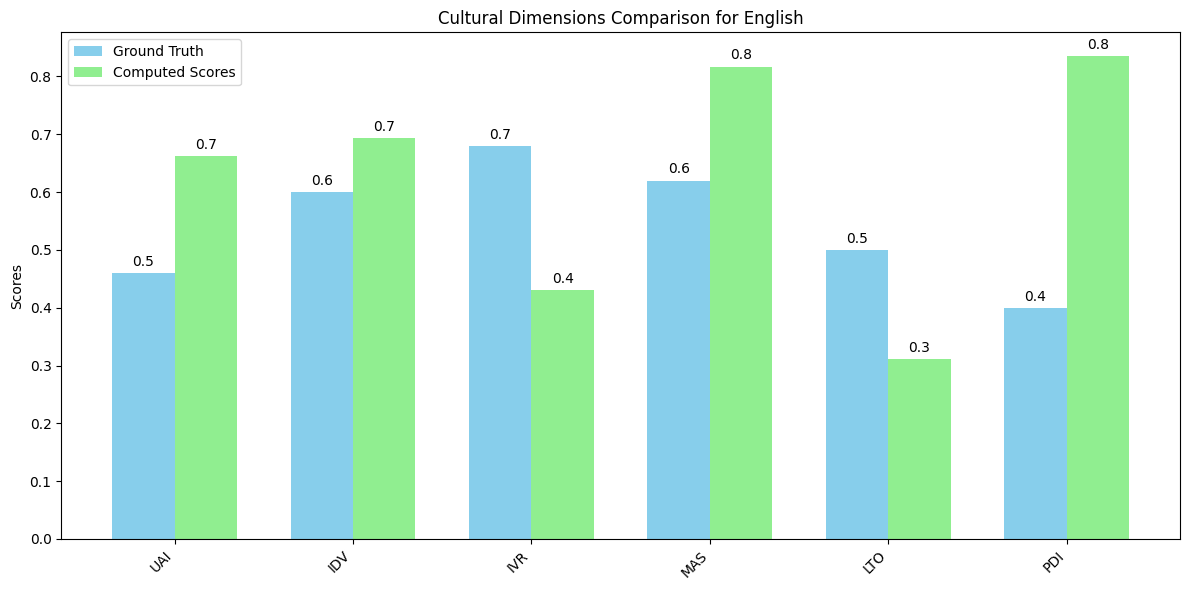

In [ ]:
# Plotting the difference between the ground truth and calculated values for each language's dimension
def plot_language_comparison(language, dimensions, ground_truth, computed_scores, title):
    N = len(dimensions)
    ind = np.arange(N)
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    ground_truth_values = [ground_truth.get(dim, 0) for dim in dimensions]
    computed_values = [computed_scores.get(dim + '.json', 0) for dim in dimensions]

    # Calculate the differences
    differences = np.array(computed_values) - np.array(ground_truth_values)

    rects1 = ax.bar(ind - width/2, ground_truth_values, width, label='Ground Truth', color='skyblue')
    rects2 = ax.bar(ind + width/2, computed_values, width, label='Computed Scores', color='lightgreen')

    # #Add the difference values on top of the bars
    # for i, diff in enumerate(differences):
    #     color = 'green' if diff >= 0 else 'red'
    #     ax.text(i, max(ground_truth_values[i], computed_values[i]), f'{diff:.1f}',
    #             ha='center', va='bottom', color=color, fontweight='bold')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(dimensions, rotation=45, ha='right')
    ax.legend()

    # Add value labels on the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

# Get all unique dimensions across all languages
all_dimensions = set()
for language in translations.keys():
    all_dimensions.update([dim.replace('.json', '') for dim in translations[language].keys()])
dimensions = list(all_dimensions)

# Generate individual charts for each language
for language in ['Yoruba', 'Malayalam', 'English']:
    plot_language_comparison(
        language,
        dimensions,
        ground_truth_scores[language],
        computed_scores[language],
        f'Cultural Dimensions Comparison for {language}'
    )